In [2]:
import os, sys
sys.path.insert(1, '../dataset')
import data_preparation
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import BertTokenizer
import torch
from utils import tag_to_word_df

# Introduction

Sentiment analysis, i.e. the analysis of the feeling expressed in a sentence, is a leading application area in natural language processing. Indeed, it has attract the interest of brands, which are interesent analyzing customer feedback, such as opinions in survey responses and social media conversations, so that they can tailor products and services to meet their customers’ needs.

Nevertheless, basic sentiment analysis attempt to detect the overall polarity of a sentence irrespective of the entities mentioned and their aspects. Therefore, a new task has been introduced: Aspect-based sentiment analysis (ABSA), a text analysis technique that categorizes data by aspect and identifies the sentiment attributed to each one. 

In this notebook, we provide a possible solution to two steps of ABSA:
1. Aspect term extraction (ATE);
2. Aspect-based sentiment analysis (ABSA).

# Task description

Let us consider a given sentence $s$, coming for instance from a review of a product or a social media post.
A company could be interested in getting to know the major sentiment of the sentence, i.e. whether it is positive, negative or neutral, w.r.t. each of the most important aspects of the sentence.

For example, the sentence "The food was delicious, but the prices were a bit high" has two different polarities to point out, each of which is attributed to a different aspect. Indeed, the sentiment concerning the **food** is positive, while the sentiment concerning the **prices** is negative, and both these informations could be separately interesting to a company.

Thus, in order to extract such information, we need to first identify the aspects of the sentence, and then to extract the sentiment associated to each of them. These are the two separated tasks we are going to approach in this notebook.

1. Aspect-based term extraction (ABTE): given sentence, identify all apect terms present in the sentence;
2. Aspect-based sentiment analysis (ABSA): given sentence and an aspect term, identify the sentiment associated to that aspect term.

Clearly, the first task can be seen as a preprocessing step in order to perform the second task, thus, if we deal with data in which the aspects are not manually annotated we should perform ATE and then ABSA. On the other hand, ifthe aspects are already manually annotated, we can directly perform ABSA in order to extract the sentiment associated to each aspect.


# Dataset

In order to train and test our models we use a dataset containing restaurant reviews, taken from a preprocessed version, available at [1], of the SemEval-2014 ABSA Task [2].

Data are organized in a csv file, with the following columns:
- **Tokens**: tokenized sentence;
- **Tags**: list of tags associated to each token: '0' for non-aspect terms, '1' for beginning of terms and '2' for marks of terms;
- **Polarities**: list of polarities associated to each token: '0' for negative, '1' for neutral and '2' for positive and '-1' for non-aspect terms;

# Models

To solve the problems described above, we provide different strategies, all based on the fine-tuning of a pretrained BERT model [3], with the implementation provided by Hugging Face [4].
BERT is a bidirectional transformer pretrained using a combination of masked language modeling objective and next sentence prediction, which can be adapted to a wide range of tasks, including sentiment analysis.

### Architecture

Both tasks are approached with two different BERT based approaches: a straighforward fine-tuning and an adapter, implementation provided by AdapterHub[5].

1. **Fine-tuning** consist of taking pretrained model ('bert-base-uncased' in our case) and train in specifically for ATE and ABSE. Thus, the idea is to update the entire copy of the original pretrained model, which turns out to be not efficient. See Figure 1 below [3] for a summary of the model architecture for fine-tuning:

<p align="center">
  <img src="imgs/fine_tuning.png" width="800" />
</p>

2. **Adapter modules** have been introduced [6] as a more efficient approach than fine-tuning. In this scenario, the parameters of the original model are fixed, and one has to train only a few trainable parameters per task: these new task-specific parameters are called adaptors. See Figure 1 below [6] for a summary of the adapter architecture: 

<p align="center">
  <img src="imgs/adapter_architecture.png" width="850" />
</p>

In particular, for ATE we feed the transormer with the list of indeces of words in the vocabulary. On the other hand, in ABSE we first concatenate the aspect with the list of sentence tokens as follows:
```{note}
    ['w1', 'w2', 'w3', ... , 'wN', '[CLS]', 'aspect']
```
Then we feed the transformer with the list of indeces of words in the vocabulary.


### Optimization strategy and training

Finally, we provide two different optimization strategies, both based on the AdamW algorithm [7], with the implementation provided in Pyorch [8].
Moreover, we test both AdamW with a fixed learning rate and with a a learning rate schedueler, linear for ATE and polynomial for ABSE.

Training is performed with a batch size of 8, and 5 epochs for all the cases, as suggested for BERT models. While ATE is trained with $3\,10^{-5}$ learing rate, ABSE is trained with $10^{-3}$ learning rate since the second approach shows a less stable trend.

## Overview
The notebook is structured as follows:
1. Text preprocessing and normalization;
2. Aspect term extraction: training overview and comparison, testing, evaluation, and visualization;
3. Aspect-based sentiment analysis:  training overview and comparison, testing, evaluation, and visualization;
4. Conclusions and comparison with other results.

Since we trained 8 different models, training has been performed separately and loaded in the present notebook. Nevertheless, we show the process of training by means of a plot of the training loss.

In [2]:
#prepare data
if not os.path.exists('../dataset/prepared'):
    os.makedirs('../dataset/prepared')
data_preparation.to_csv('../dataset/atepc/restaurants_test.csv', '../dataset/prepared/restaurants_test.csv',)
data_preparation.to_csv('../dataset/atepc/restaurants_train.csv', '../dataset/prepared/restaurants_train.csv',)

# 1. Text normalization

We first perform a basic text normalization, fixing text contractions and performing spell checking by means of textblob and contractions. Results are then saved in a dedicated folder with the same format of original data.

In [51]:
# spelling check
from textblob import TextBlob
import contractions

def normalize(data):
    d = data
    def correct(token_list):
        l = token_list.replace("'", "").strip("][").split(', ')
        # abbreviations
        l = [contractions.fix(ll) for ll in l ]
        s = ' '.join(l)
        s = str(TextBlob(s).correct().words)
        return s 
    d['Tokens'] = d['Tokens'].apply(lambda x: correct(x))
    return d

#load
data = pd.read_csv('../dataset/restaurants_train.csv')
data_test = pd.read_csv('../dataset/restaurants_test.csv')

data_test = normalize(data_test)
data = normalize(data)

In [52]:
#normalized data
if not os.path.exists('../dataset/normalized'):
    os.makedirs('../dataset/normalized')
data_test.to_csv('../dataset/normalized/restaurants_test.csv', index=False)
data.to_csv('../dataset/normalized/restaurants_train.csv', index=False)

# 2. Aspect term extraction
Let us consider the 4 scenarios already discussed (fine-tuning, adapter, fine-tuning with scheduler, adapter with scheduler) and load the models trained with 5 epochs, batch size 8, and a learning rate of $3\,10^{-5}$.

for each case, we compute test accuracy, test classification report, predict the labels and save all the results. Same process is done for training set.

In [404]:
from abte import ABTEModel

batch = 8
lr = 3*1e-5
epochs = 5

def run_ABTE_test_train(adapter, lr_schedule):
    if adapter:
        if lr_schedule: dir_name  = "model_ABTE_adapter_scheduler"
        else: dir_name = "model_ABTE_adapter"
    else:
        if lr_schedule: dir_name  = "model_ABTE_scheduler"
        else: dir_name = "model_ABTE"

    #load
    data = pd.read_csv('../dataset/normalized/restaurants_train.csv')
    data_test = pd.read_csv('../dataset/normalized/restaurants_test.csv')

    # define parameters for model
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # define model
    modelABTE = ABTEModel(tokenizer, adapter=adapter)

    # load model and predict
    model_path = dir_name+'/model_lr3.0000000000000004e-05_epochs4_batch8.pkl'
    test_accuracy, test_report = modelABTE.test(data_test, load_model=model_path, device=DEVICE)
    test_pred, test_targets = modelABTE.predict_batch(data_test, load_model=model_path, device=DEVICE)

    train_accuracy, train_report = modelABTE.test(data, load_model=model_path, device=DEVICE)
    train_pred, train_targets = modelABTE.predict_batch(data, load_model=model_path, device=DEVICE)

    #save results
    if not os.path.exists('/results'):
        os.makedirs(dir_name+'/results')

    #report
    with open(dir_name+'/results/test_report_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), 'w') as f:
        for r in test_report.split('\n'):
            f.write(r + '\n')

    with open(dir_name+'/results/train_report_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), 'w') as f:
        for r in train_report.split('\n'):
            f.write(r + '\n')

    #predictions
    data_test['Predicted'] = test_pred
    data_test['Actual'] = test_targets
    data_test.to_csv(dir_name+'/results/test_pred_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), index=False)

    data['Predicted'] = train_pred
    data['Actual'] = train_targets
    data.to_csv(dir_name+'/results/train_pred_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), index=False)

    #accuracy
    test_accuracy = np.array(test_accuracy)
    train_accuracy = np.array(train_accuracy)

    with open(dir_name+'/results/test_accuracy_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), 'w') as f:
        f.write(str(test_accuracy))
    with open(dir_name+'/results/train_accuracy_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), 'w') as f:
        f.write(str(train_accuracy))

In [ ]:

run_ABTE_test_train(False, False)
run_ABTE_test_train(False, True)
run_ABTE_test_train(True, False)
run_ABTE_test_train(True, True)

### 2.a Training history

In the following figure, we plot the training loss and the validation loss for the fine-tuning and adapter cases, both with and without scheduler. Let us point out that both panels represent the same data, but int the right panel the loss function tren is shown in log scale. 

We can observe that all of the models exhibit a similar behavior, with several oscillations in the loss function trend. Nevertheless, we could point out, see left panel, that the combination of adapter and scheduler allows to reduce the amplitude of the oscillations, leading to more stable results and a lower loss function in general.

Note also that the first couple of iterations show a fast decay, while as training progresses, the decreasing trend gets slower. Finally, the log scaled plot shows that the learning curve starts to get flat during the last epoch, thus we fix 5 epochs in order to avoid overfitting.


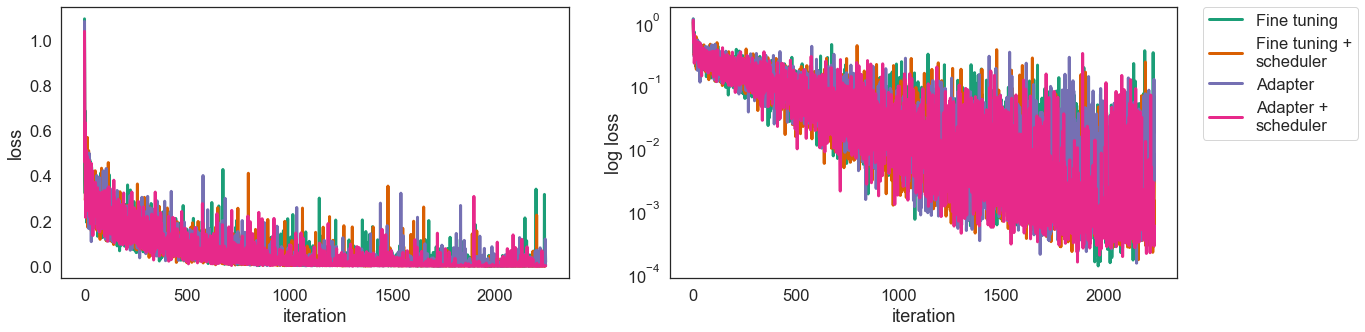

In [324]:
lossABTE = np.loadtxt('model_ABTE/losses_lr3.0000000000000004e-05_epochs5_batch8.txt')
lossABTE_AS = np.loadtxt('model_ABTE_adapter_scheduler/losses_lr3.0000000000000004e-05_epochs5_batch8.txt')
lossABTE_S = np.loadtxt('model_ABTE_scheduler/losses_lr3.0000000000000004e-05_epochs5_batch8.txt')
lossABTE_A = np.loadtxt('model_ABTE_adapter/losses_lr3.0000000000000004e-05_epochs5_batch8.txt')

sns.set_theme (style="white", rc={"lines.linewidth": 3}, font_scale=1.5, palette="Dark2")
fig, ax = plt.subplots(1,2,figsize=(20,5))

for i in [0,1]:
    sns.lineplot(range(len(lossABTE)), lossABTE, ax=ax[i], label = 'Fine tuning')
    sns.lineplot(range(len(lossABTE_S)), lossABTE_S, ax=ax[i], label = 'Fine tuning +\nscheduler')
    sns.lineplot(range(len(lossABTE_A)), lossABTE_A, ax=ax[i], label = 'Adapter')
    sns.lineplot(range(len(lossABTE_AS)), lossABTE_AS, ax=ax[i], label = 'Adapter +\nscheduler')

    ax[i].set_xlabel('iteration')
    ax[i].set_ylabel('loss')
ax[1].set_yscale('log')
ax[1].set_ylabel('log loss')
ax[0].legend().set_visible(False)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

if not os.path.isdir('results_ABTE'):
    os.makedirs('results_ABTE')
fig.savefig('results_ABTE/loss_lr{:.5f}_epochs{}_batch{}.pdf'.format(lr, epochs, batch), dpi=300, bbox_inches='tight')

### 2.b Classification reports

Here we propose the classification reports for all the four models trained in the previous sections.
In particular we can make the following observations:

1. **FINE-TUNING**: the model tends to overlearn, since all the metrics concerning the train dataset are close to 1, while performances on the test dataset are low in terms of f1-score. The 0.92 accuracy of test data is mainly due to correct identification of non-aspect terms, which is not the matter of interest;

2. **FINE-TUNING WITH SCHEDULER**: introducting the scheduling prevent the model from overlearning, and all metrics show comparable performances on train and test dataset. In general, the task is accomplished with good results in terms of accuracy, f1-score is greter or equal than 0.65.

3. **ADAPTER**: this approach shows similar results to fine-tuning+scheduler, oscillations may tend to increase precision and reduce recall or vice-versa, but still with similar f1-score.

4. **ADAPTER WITH SCHEDULER**: this approach shows the best results overall, with lowest overleaning tendency and higher precision.

In [3]:
from utils import classification_report_read, print_aligned

In [491]:
test_ATE = classification_report_read('model_ABTE/results/test_report_lr3.0000000000000004e-05_epochs5_batch8.csv')
train_ATE = classification_report_read('model_ABTE/results/train_report_lr3.0000000000000004e-05_epochs5_batch8.csv')
print_aligned(test_ATE, train_ATE, 'TEST FINE-TUNING', 'TRAIN FINE-TUNING')

	 TEST FINE-TUNING 						 TRAIN FINE-TUNING
              precision    recall  f1-score   support 		               precision    recall  f1-score   support
 		 
        none       0.96      0.97      0.96     48484 		         none       1.00      1.00      1.00    180354
 start of AT       0.56      0.48      0.51      3091 		  start of AT       0.99      0.99      0.99      9359
  mark of AT       0.47      0.43      0.45      1602 		   mark of AT       0.98      0.96      0.97      3795
 		 
    accuracy                           0.92     53177 		     accuracy                           1.00    193508
   macro avg       0.66      0.63      0.64     53177 		    macro avg       0.99      0.98      0.99    193508
weighted avg       0.92      0.92      0.92     53177 		 weighted avg       1.00      1.00      1.00    193508
 		 
 		 


In [494]:
test_ATE_S = classification_report_read('model_ABTE_scheduler/results/test_report_lr3.0000000000000004e-05_epochs5_batch8.csv')
train_ATE_S = classification_report_read('model_ABTE_scheduler/results/train_report_lr3.0000000000000004e-05_epochs5_batch8.csv')
print_aligned(test_ATE_S, train_ATE_S, 'TEST FINE-TUNING + SCHEDULER', 'TRAIN FINE-TUNING + SCHEDULER')

	 TEST FINE-TUNING + SCHEDULER 						 TRAIN FINE-TUNING + SCHEDULER
              precision    recall  f1-score   support 		               precision    recall  f1-score   support
 		 
        none       0.97      0.99      0.98     66427 		         none       0.98      0.98      0.98    223788
 start of AT       0.69      0.61      0.65      4022 		  start of AT       0.67      0.63      0.65     11416
  mark of AT       0.77      0.63      0.69      2141 		   mark of AT       0.76      0.71      0.73      4710
 		 
    accuracy                           0.95     72590 		     accuracy                           0.96    239914
   macro avg       0.81      0.74      0.77     72590 		    macro avg       0.80      0.77      0.79    239914
weighted avg       0.95      0.95      0.95     72590 		 weighted avg       0.96      0.96      0.96    239914
 		 
 		 


In [493]:
test_ATE_A = classification_report_read('model_ABTE_adapter/results/test_report_lr3.0000000000000004e-05_epochs5_batch8.csv')
train_ATE_A = classification_report_read('model_ABTE_adapter/results/train_report_lr3.0000000000000004e-05_epochs5_batch8.csv')
print_aligned(test_ATE_A, train_ATE_A, 'TEST ADAPTER', 'TRAIN ADAPTER')

	 TEST ADAPTER 						 TRAIN ADAPTER
              precision    recall  f1-score   support 		               precision    recall  f1-score   support
 		 
        none       0.97      0.98      0.98     66884 		         none       0.98      0.98      0.98    223434
 start of AT       0.67      0.59      0.63      4022 		  start of AT       0.66      0.61      0.63     11416
  mark of AT       0.66      0.70      0.68      2141 		   mark of AT       0.65      0.76      0.70      4710
 		 
    accuracy                           0.95     73047 		     accuracy                           0.96    239560
   macro avg       0.77      0.75      0.76     73047 		    macro avg       0.76      0.78      0.77    239560
weighted avg       0.95      0.95      0.95     73047 		 weighted avg       0.96      0.96      0.96    239560
 		 
 		 


In [495]:
test_ATE_AS = classification_report_read('model_ABTE_adapter_scheduler/results/test_report_lr3.0000000000000004e-05_epochs5_batch8.csv')
train_ATE_AS = classification_report_read('model_ABTE_adapter_scheduler/results/train_report_lr3.0000000000000004e-05_epochs5_batch8.csv')
print_aligned(test_ATE_AS, train_ATE_AS, 'TEST ADAPTER + SCHEDULER', 'TRAIN ADAPTER + SCHEDULER')

	 TEST ADAPTER + SCHEDULER 						 TRAIN ADAPTER + SCHEDULER
              precision    recall  f1-score   support 		               precision    recall  f1-score   support
 		 
        none       0.98      0.99      0.98     65477 		         none       0.98      0.99      0.98    227086
 start of AT       0.70      0.68      0.69      4022 		  start of AT       0.69      0.66      0.68     11416
  mark of AT       0.83      0.61      0.70      2141 		   mark of AT       0.78      0.67      0.72      4710
 		 
    accuracy                           0.96     71640 		     accuracy                           0.96    243212
   macro avg       0.83      0.76      0.79     71640 		    macro avg       0.82      0.77      0.79    243212
weighted avg       0.96      0.96      0.96     71640 		 weighted avg       0.96      0.96      0.96    243212
 		 
 		 


### 2.c Results visualization
In this section we propose a possible visualization of final results. First we show the final datafram, with the comparison between the different sequences and the decoded tokens which correspond to gold terms and predicted terms.

Finally, we show, by means of a word clod that the predicted terms are similar to the gold terms.

In [406]:
# adapter training 
dftest = pd.read_csv('model_ABTE_adapter/results/test_pred_lr3.0000000000000004e-05_epochs5_batch8.csv')
test_pred = dftest['Predicted']

test_tags_real = [t.strip('][').split(', ') for t in data_test['Tags']]
test_tags_real = [[int(i) for i in t] for t in test_tags_real]

test_pred = [t.strip('][').split(', ') for t in test_pred]
test_pred = [[int(i) for i in t] for t in test_pred]


ABTE_data = tag_to_word_df(data_test, 'gold terms', test_tags_real)
ABTE_data = tag_to_word_df(ABTE_data, 'pred terms', test_pred)
ABTE_data.head(10)

,Tokens,Tags,Polarities,Predicted,Actual,gold terms,pred terms
0,"['The', 'bread', 'is', 'top', 'notch', 'as', '...","[0, 1, 0, 0, 0, 0, 0, 0]","[-1, 2, -1, -1, -1, -1, -1, -1]","[None, 1, None, None, None, None, None]","[None, 1, None, None, None, None, None]",[bread],[bread]
1,"['I', 'have', 'to', 'say', 'they', 'have', 'on...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0]","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, 2,...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...",[delivery],"[delivery, times]"
2,"['Good', 'is', 'always', 'fresh', 'and', 'hot'...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]","[1, None, None, None, None, None, None, None, ...","[1, None, None, None, None, None, None, None, ...",[Good],[Good]
3,"['Did', 'I', 'mention', 'that', 'the', 'coffee...","[0, 0, 0, 0, 0, 1, 0, 0, 0]","[-1, -1, -1, -1, -1, 2, -1, -1, -1]","[None, None, None, None, None, 1, None, None]","[None, None, None, None, None, 1, None, None]",[coffee],[coffee]
4,"['Certainly', 'not', 'the', 'best', 'such', 'i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...",[clean],[]
5,"['I', 'trust', 'the', 'people', 'at', 'To', 'T...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[-1, -1, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1]","[None, None, None, 1, None, None, None, None, ...","[None, None, None, 1, None, None, None, None, ...",[people],"[people, To]"
6,"['Straight-forward', 'no', 'surprise', 'very',...","[0, 0, 0, 0, 0, 0, 0, 1, 2, 0]","[-1, -1, -1, -1, -1, -1, -1, 2, 2, -1]","[None, None, None, None, None, None, None]","[None, None, None, None, None, None, None]",[],[]
7,"['BEST', 'spice', 'tune', 'roll', 'great', 'as...","[0, 0, 0, 0, 0, 0, 1, 2, 0]","[-1, -1, -1, -1, -1, -1, 2, 2, -1]","[None, None, None, None, None, None, 1]","[None, None, None, None, None, None, 1]",[],[spice]
8,"['BEST', 'spice', 'tune', 'roll', 'great', 'as...","[0, 1, 2, 2, 0, 0, 0, 0, 0]","[-1, 2, 2, 2, -1, -1, -1, -1, -1]","[None, 1, 1, 1, None, None, None]","[None, 1, 1, 1, None, None, None]",[spice],[spice]
9,"['Cry', 'the', 'rose', 'roll', 'LRB', 'not', '...","[0, 0, 1, 2, 0, 0, 0, 1, 0, 0]","[-1, -1, 2, 2, -1, -1, -1, -1, -1, -1]","[None, None, 1, 1, None, None, None, -1, None]","[None, None, 1, 1, None, None, None, None, None]","[rose, menu]",[rose]


#### Word clouds

Visualization of the most frequent aspect words as a word cloud, target vs predicted. It is easy to notice that the two clouds are very similar, i.e. we can predict the correct aspect terms with a reasonable frequency.

In [104]:
def word_cloud (data):
    from wordcloud import WordCloud
    wordcloud = WordCloud( collocations=False,
                          background_color="cornflowerblue",
                          colormap="magma",
                          max_words=50).generate(data)

    return wordcloud

def target_predicted_wordcloud(targets, predicted, file_name):
    
    sns.set_theme(style='white', font_scale=2)
    fig, ax = plt.subplots(1, 2, figsize=(22, 6))
    ax[0].imshow(word_cloud(targets))
    ax[0].axis("off")
    ax[0].set_title("Target")
    ax[1].imshow(word_cloud(predicted))
    ax[1].axis("off")
    ax[1].set_title("Predicted")
    fig.savefig(file_name, dpi=300, bbox_inches='tight')

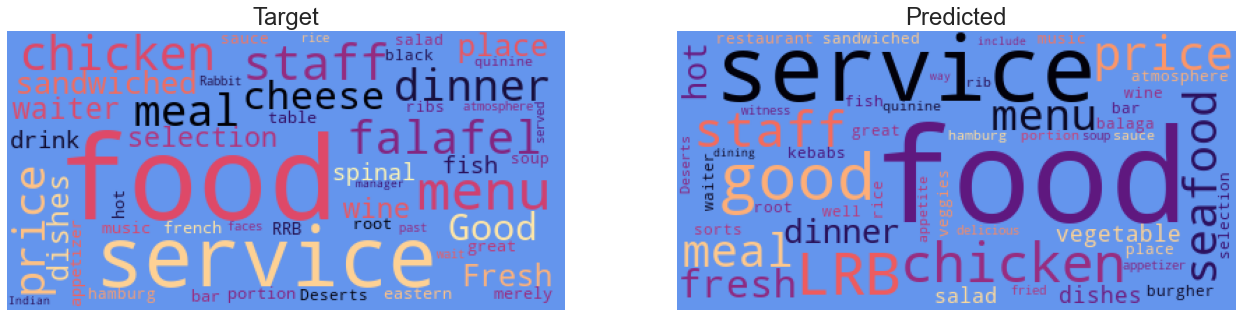

In [499]:
# from utils import target_predicted_wordcloud
import itertools

gold_terms = ABTE_data['gold terms'].values.flatten().tolist()
gold_terms = list(itertools.chain(*gold_terms))

pred_terms = ABTE_data['pred terms'].values.flatten().tolist()
pred_terms = list(itertools.chain(*pred_terms))
target_predicted_wordcloud(' '.join(gold_terms), ' '.join(pred_terms), "results_ABTE/adapter_extracted_terms_wordcloud.pdf")

# 3. Aspect-based sentiment analysis
we consider the 4 scenarios as above (fine-tuning, adapter, fine-tuning with scheduler, adapter with scheduler) and load the models trained with 5 epochs, batch size 8, and a learning rate  $10^{-5}$.

For each case, we compute test accuracy, test classification report, predict the labels and save all the results. Same process is done for training set.

In [500]:
from absa import ABSAModel

#save results
batch = 8
lr = 1e-5
epochs = 5

def run_ABSA_test_train(adapter, lr_schedule):
    if adapter:
        if lr_schedule: dir_name_s  = "model_ABSA_adapter_scheduler"
        else: dir_name_s = "model_ABSA_adapter"
    else:
        if lr_schedule: dir_name_s  = "model_ABSA_scheduler"
        else: dir_name_s = "model_ABSA"

    #load
    data = pd.read_csv('../dataset/normalized/restaurants_train.csv')
    data_test = pd.read_csv('../dataset/normalized/restaurants_test.csv')

    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    modelABSA = ABSAModel(tokenizer, adapter=adapter)

    model_path = dir_name_s+'/model_lr1e-05_epochs4_batch8.pkl'
    test_accuracy, test_report = modelABSA.test(data_test, load_model=model_path, device=DEVICE)
    test_pred, test_pol = modelABSA.predict_batch(data_test, load_model=model_path, device=DEVICE)

    train_accuracy, train_report = modelABSA.test(data, load_model=model_path, device=DEVICE)
    train_pred, train_pol = modelABSA.predict_batch(data, load_model=model_path, device=DEVICE)

    #save results
    if not os.path.exists(dir_name_s+'/results'):
        os.makedirs(dir_name_s+'/results')

    #report
    with open(dir_name_s+'/results/test_report_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), 'w') as f:
        for r in test_report.split('\n'):
            f.write(r + '\n')

    with open(dir_name_s+'/results/train_report_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), 'w') as f:
        for r in train_report.split('\n'):
            f.write(r + '\n')

    #predictions
    data_test['Predicted'] = test_pred
    data_test['Actual'] = test_pol
    data_test.to_csv(dir_name_s+'/results/test_pred_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), index=False)

    data['Predicted'] = train_pred
    data['Actual'] = train_pol
    data.to_csv(dir_name_s+'/results/train_pred_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), index=False)

    #accuracy
    test_accuracy = np.array(test_accuracy)
    train_accuracy = np.array(train_accuracy)

    with open(dir_name_s+'/results/test_accuracy_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), 'w') as f:
        f.write(str(test_accuracy))
    with open(dir_name_s+'/results/train_accuracy_lr{}_epochs{}_batch{}.csv'.format(lr, epochs, batch), 'w') as f:
        f.write(str(train_accuracy))


In [403]:
run_ABSA_test_train(False, False)
run_ABSA_test_train(False, True)
run_ABSA_test_train(True, False)
run_ABSA_test_train(True, True)

### 3.a Training history

In the following figure, we plot the training loss and the validation loss for the fine-tuning and adapter cases, both with and without scheduler. 

We can observe that all of the models exhibit a similar behavior, with same oscillating trend. Note also that the order of magnitude is higher if compared to ATE model. Finally, let us highligh that in order to limit the overfitting, one should not train the model for more than 5 epochs. Indeed, we tested the training up to 10 epochs and computed the correspondent test accuracy: convergence is achieved after 5 epochs, even tough loss function keeps decreasing, thus it is better to limit the number of epochs chosen to train the model.



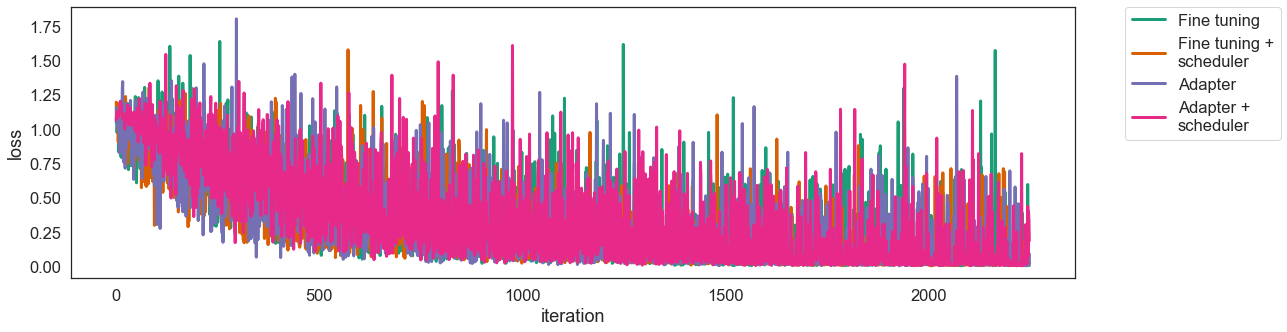

In [398]:
lossABTE = np.loadtxt('model_ABSA/losses_lr1e-05_epochs5_batch8.txt')
lossABTE_AS = np.loadtxt('model_ABSA_adapter_scheduler/losses_lr1e-05_epochs5_batch8.txt')
lossABTE_S = np.loadtxt('model_ABSA_scheduler/losses_lr1e-05_epochs5_batch8.txt')
lossABTE_A = np.loadtxt('model_ABSA_adapter/losses_lr1e-05_epochs5_batch8.txt')

sns.set_theme (style="white", rc={"lines.linewidth": 3}, font_scale=1.5, palette="Dark2")
fig, ax = plt.subplots(figsize=(18,5))

sns.lineplot(range(len(lossABTE)), lossABTE, ax=ax, label = 'Fine tuning')
sns.lineplot(range(len(lossABTE_S)), lossABTE_S, ax=ax, label = 'Fine tuning +\nscheduler')
sns.lineplot(range(len(lossABTE_A)), lossABTE_A, ax=ax, label = 'Adapter')
sns.lineplot(range(len(lossABTE_AS)), lossABTE_AS, ax=ax, label = 'Adapter +\nscheduler')

ax.set_xlabel('iteration')
ax.set_ylabel('loss')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

if not os.path.isdir('results_ABSA'):
    os.makedirs('results_ABSA')

fig.savefig('results_ABSA/loss_lr{:.5f}_epochs{}_batch{}.pdf'.format(lr, epochs, batch), dpi=300, bbox_inches='tight')

### 2.b Classification reports

Here we propose the classification reports for all the four models trained in the previous sections and tested on test dataset.

Fine-tuning with scheduler and simple adapter show the same results, with high precision and recall for negative and positive aspects, but low recall for neutral aspects, which means that we have difficulties in predicting neutral aspects. Low recall for neutral aspects can be also highlighted in fine-tuning and adapter+scheduler.

In general, fine-tuning and adapter+scheduler exhibit lower values of precision/recall, thus of f1-score, if compared with the other two. Therefore, we can conclude that ine-tuning with scheduler and simple adapter are the best models to identify negative and positive polarities, even tough they have high proabability of failing in identifying neutral aspects.

These results could be easily understood, since the concept of "neutral aspect" is less clear than 'positive' and 'negative' polarities, also in a common spoken language. Moreover, if we think of possible applications of the provided architecture, we could argue that a possible customer of the model we build would be more interested in identifying negative and positive aspects, rather than neutral ones. As a consequence, we can conclude that even if it has limitations, the provided model can still be applied with good results to detect whether a sentence is positive or negative w.r.t. a certain aspect.

In [6]:
test_ABSA = classification_report_read('model_ABSA/results/test_report_lr1e-05_epochs5_batch8.csv')
test_ABSA_S = classification_report_read('model_ABSA_scheduler/results/test_report_lr1e-05_epochs5_batch8.csv')
test_ABSA_A = classification_report_read('model_ABSA_adapter/results/test_report_lr1e-05_epochs5_batch8.csv')
test_ABSA_AS = classification_report_read('model_ABSA_adapter_scheduler/results/test_report_lr1e-05_epochs5_batch8.csv')

print_aligned(test_ABSA, test_ABSA_S, 'TEST FINE-TUNING', 'TEST FINE-TUNING+SCHEDULER')
print_aligned(test_ABSA_A, test_ABSA_AS, 'TEST ADAPTER', 'TRAIN ADAPTER+SCHEDULER')

	 TEST FINE-TUNING 						 TEST FINE-TUNING+SCHEDULER
              precision    recall  f1-score   support 		               precision    recall  f1-score   support
 		 
    negative       0.75      0.80      0.77       267 		     negative       0.86      0.76      0.81       267
     neutral       0.62      0.41      0.50       179 		      neutral       0.70      0.36      0.47       179
    positive       0.84      0.89      0.87       673 		     positive       0.82      0.96      0.88       673
 		 
    accuracy                           0.80      1119 		     accuracy                           0.82      1119
   macro avg       0.74      0.70      0.71      1119 		    macro avg       0.79      0.69      0.72      1119
weighted avg       0.79      0.80      0.79      1119 		 weighted avg       0.81      0.82      0.80      1119
 		 
 		 
	 TEST ADAPTER 						 TRAIN ADAPTER+SCHEDULER
              precision    recall  f1-score   support 		               precision    recall  f1-score   s

### 2.c Confusion matrix

Finally, let us go deeper in the analysis of the provided architecture by showing the confusion matrices for the four models.

The main observation is that all the model show high rate of true positive for positive polarity. Moreover, the most problematic classification concerns the neutral aspect, which is likely misclassified as having positive polarity, and the misclassification of negatives as potitives is also non negligible.

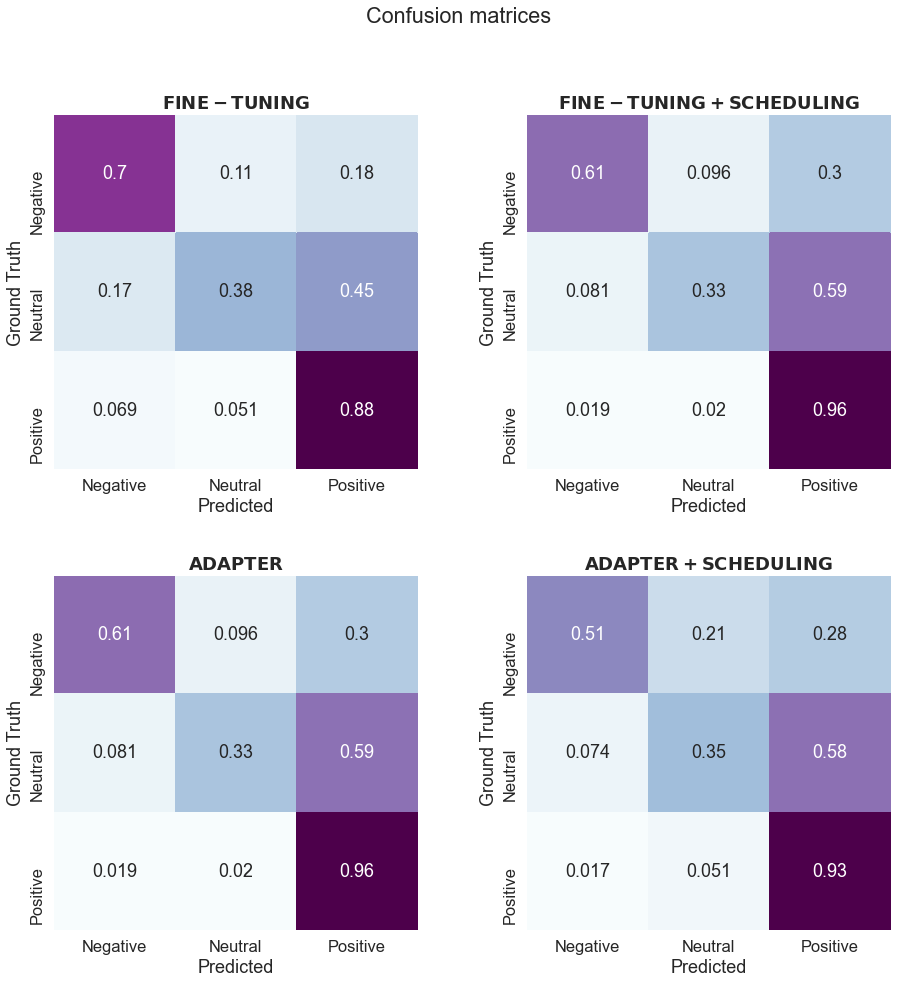

In [5]:
# confusion matrix 
def plot_confusion_matrix(predictions, labels, title, ax, 
                          cmap='BuPu'):
    """
    This function prints and plots the confusion matrix.
    """
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(labels, predictions, normalize = 'true')
    cm = cm[1:,1:]
    sns.set_theme (style="white", rc={"lines.linewidth": 3}, font_scale=1.5)
    sns.heatmap(cm, annot=True,  cmap=cmap, ax=ax, cbar=False)
    ax.set_title(title)
    ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
    ax.set_yticklabels(['Negative', 'Neutral', 'Positive'])
    ax.set_ylabel('Ground Truth'),ax.set_xlabel('Predicted')
    
def plot_confusion_matrix_df(df_path, title, ax, cmap='BuPu'):

    df = pd.read_csv(df_path)
    pred = df['Predicted'].apply(lambda x: [int (i) if i !='None' else -2 for i in x.strip('][').split(', ')]).to_list()
    gtruth = df['Actual'].apply(lambda x: [int (i) if i !='None' else -2 for i in x.strip('][').split(', ')]).to_list()
    predicted, ground_truth = [], []
    for i in range(len(pred)):
        predicted+=pred[i]
        ground_truth+=gtruth[i]
    plot_confusion_matrix(predicted, ground_truth, title, ax, cmap=cmap)

def compare_confusion_mat():
    df = 'model_ABSA/results/test_pred_lr1e-05_epochs5_batch8.csv'
    dfS = 'model_ABSA_scheduler/results/test_pred_lr1e-05_epochs5_batch8.csv'
    dfA = 'model_ABSA_adapter/results/test_pred_lr1e-05_epochs5_batch8.csv'
    dfAS = 'model_ABSA_adapter_scheduler/results/test_pred_lr1e-05_epochs5_batch8.csv'
    fig, ax = plt.subplots(2,2,figsize=(15,15))
    #set space between subplots
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    fig.suptitle('Confusion matrices')
    plot_confusion_matrix_df(df, r'$\bf{FINE-TUNING}$', ax[0][0])
    plot_confusion_matrix_df(dfS, r'$\bf{FINE-TUNING + SCHEDULING}$', ax[0][1])
    plot_confusion_matrix_df(dfA, r'$\bf{ADAPTER}$', ax[1][0])
    plot_confusion_matrix_df(dfAS, r'$\bf{ADAPTER + SCHEDULING}$', ax[1][1])
    
    fig.savefig('results_ABSA/CMatrix_test.png', dpi=300, bbox_inches='tight')

compare_confusion_mat()

### 2.d Results visualization

Finally, let us show how to use the provided model to predict the polarity of a sentence w.r.t. a specific aspect with any sentence. It is sufficient to call the method predict of the class ABSAModel, examples follow.


In [298]:
def predict_sentiment(review, aspect, model, model_path):
    x, y, z = modelABSA.predict(review, aspect, load_model=model_path)
    
    if y == 1:
        return 'The review "{}" \nw.r.t. the aspect "{}" is positive\n'.format(review, aspect)
    elif y == 0:
        return 'The review "{}" \nw.r.t. the aspect "{}" is neutral\n'.format(review, aspect)
    else:
        return 'The review "{}" \nw.r.t. the aspect "{}" is negative\n'.format(review, aspect)

In [534]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_path = 'model_ABSA_adapter_scheduler/model_lr1e-05_epochs4_batch8.pkl'
modelABSA = ABSAModel(tokenizer, adapter=True) 

print (predict_sentiment("they make the BEST spice tuna roll in town, and the asian salad is ok", "tuna", modelABSA, model_path)+"\n")

print (predict_sentiment("the food is fantastic, but the prices were too high", "prices", modelABSA, model_path)+"\n")
print (predict_sentiment("the food is fantastic, but the prices were too high", "food", modelABSA, model_path)+"\n")

print (predict_sentiment("the chicken tastes like plastic, even tough they make the best ", "chicken", modelABSA, model_path)+"\n")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertAdapterModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertAdapterModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertAdapterModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The review "they make the BEST spice tuna roll in town, and the asian salad is ok" 
w.r.t. the aspect "tuna" is positive

The review "the food is fantastic, but the prices were too high" 
w.r.t. the aspect "prices" is negative

The review "the food is fantastic, but the prices were too high" 
w.r.t. the aspect "food" is positive

The review "the chicken tastes like plastic, even tough they make the best " 
w.r.t. the aspect "chicken" is negative



## 4. Conclusions and comparison with other results.

Let us now draw some conclusions with refer to the actual SemEval 2014 task [2].

The following table shows results for the aspect-term extraction task:

<p align="center">
  <img src="imgs/ate.png" width="300" />
</p>

Recall that our best model (adapter+scheduler) provides an average f1 score of 0.70 on the classification of an aspect-term, which is in the range of the other goups which partecipated to the SemEval.

Moreover, the following table shows f1-score for the aspect-based sentiment analysis task, considering all the possible polarities for all the groups who partecipated to the task:

<p align="center">
  <img src="imgs/f1absa.png" width="180" />
</p>

If we consider neutral, positive and negative polarities, our best model (fine-tuning + scheduler and adapter) provide an average f1-score of 0.72, which is in the range.

## Aknowledgements

The general structure of the model (i.e. padding, dataset construction...) has been taken from [1], nevetheless we organized the model into a user-friendly class structure which provides a simple interface to the model. Moreover, we changed the optimization strategy, using AdamW instead of a generic Adam, introducing the learning rate scheduling and Adapter option as an alternative to fine-tuning.
Finally, we add a detailed analysis of the model performance, including the study of the training history, confusion matrix and visualization


## References:

[1] **Aspect-Term-Extraction-and-Analysis**, https://github.com/1tangerine1day/Aspect-Term-Extraction-and-Analysis

[2] Maria Pontiki, Dimitris Galanis, John Pavlopoulos, Harris Papageorgiou, Ion Androutsopoulos, and Suresh Manandhar. 2014. **SemEval-2014 Task 4: Aspect Based Sentiment Analysis.** In Proceedings of the 8th International Workshop on Semantic Evaluation (SemEval 2014), pages 27–35, Dublin, Ireland. Association for Computational Linguistics.

[3] Devlin, Jacob and Chang, Ming-Wei and Lee, Kenton and Toutanova, Kristina, **BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding**, DOI: 10.48550/ARXIV.1810.04805

[4] **HuggingFace BERT models**, https://huggingface.co/docs/transformers/model_doc/bert

[5] **AdapterHub: A Framework for Adapting Transformers**, Jonas Pfeiffer et al., Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP 2020): Systems Demonstrations, https://www.aclweb.org/anthology/2020.emnlp-demos.7

[6] Houlsby, Neil and Giurgiu, Andrei and Jastrzebski, Stanislaw and Morrone, Bruna and de Laroussilhe, Quentin and Gesmundo, Andrea and Attariyan, Mona and Gelly, Sylvain, **Parameter-Efficient Transfer Learning for NLP**, DOI: 10.48550/ARXIV.1902.00751

[7] Loshchilov Ilya, Hutter Frank, **Decoupled Weight Decay Regularization**, DOI: 10.48550/ARXIV.1711.05101

[8] PyTorch: An Imperative Style, High-Performance Deep Learning Library}, Paszke Adam,  Gross Sam, Massa Francisco, Lerer Adamm, Bradbury James, Chanan Gregory, Killeen Trevor, Lin Zeming, Gimelshein Natalia, Antiga Luca, Desmaison Alban, Kopf Andreas, Yang Edward, DeVit Zachary, Raison Martin, Tejani Alykhan, Chilamkurthy Sasank, Steiner Benoit, Fang Lu, Bai Junjie, Chintala Soumith, http://papers.neurips.cc/paper/9015-pytorch-an-imperative-style-high-performance-deep-learning-library.pdf
